## Probabilistic modeling EGU25

This notebook is a small example of how to introduce uncertainty to structural geological models. 

In addition to gempy it requires pytorch (https://pytorch.org/) and pyro (https://pyro.ai/) as dependencies.

In [1]:
# Importing GemPy
import gempy as gp
import gempy_viewer as gpv

# Load AvailableBackends for Pytorch support
from gempy_engine.config import AvailableBackends

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

# Imports specifically required for probabilistic modeling
import pyro
import pyro.distributions as dist
import torch

# For progress bar and to suppress gempy prints
import sys
import os
import tqdm

Setting Backend To: AvailableBackends.numpy


### 1) Original model

In [2]:
# Define resolution separately as it is needed later
resolution = [50,3,50]

In [3]:
# Create a GeoModel instance
geo_model = gp.create_geomodel(
    project_name='Prob_Model',
    extent=[0, 1000, 490, 510, 0, 1000],
    resolution=resolution,
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations="model5_orientations.csv",
        path_to_surface_points="model5_surface_points_2.csv"
    )
)

# Map geological series to surfaces
gp.map_stack_to_surfaces(
    gempy_model=geo_model,
    mapping_object={
        "Fault_Series": ('fault'),
        "Strat_Series": ('rock2', 'rock1')
    }
)

# Define youngest structural group as fault
gp.set_is_fault(geo_model, ["Fault_Series"])

# Compute a result for the model
gp.compute_model(geo_model, 
                 engine_config=gp.data.GemPyEngineConfig(
                    backend=AvailableBackends.PYTORCH)
                 )

Setting Backend To: AvailableBackends.PYTORCH


Solutions(4 Octree Levels, 3 DualContouringMeshes)

C:\Users\vonha\miniconda3\envs\gempy\Lib\site-packages\gempy_viewer\API\_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


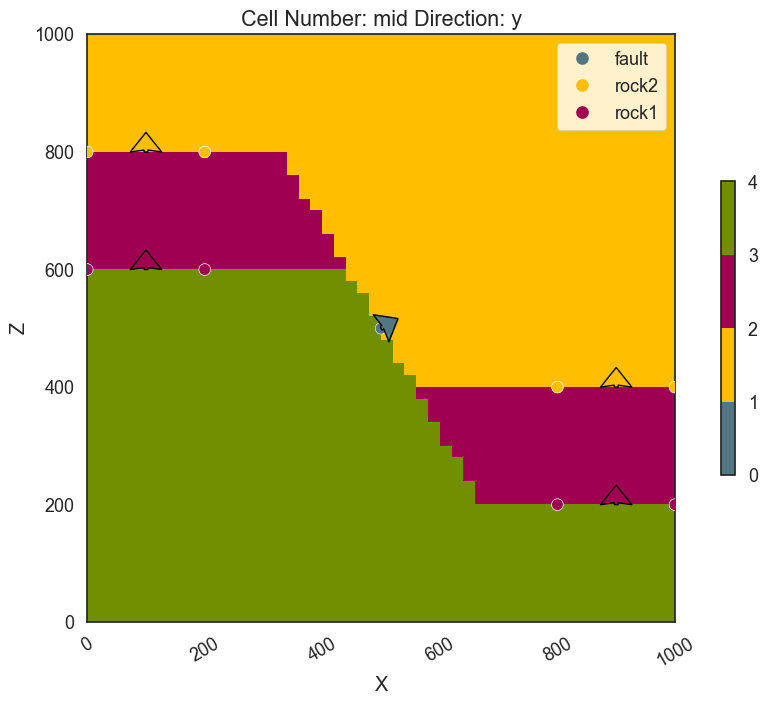

In [4]:
# 2D visualization of resulting model
gpv.plot_2d(geo_model, show_boundaries=False, show_lith=True) 

### 2) Stochastic model

In [5]:
# Take a look at the input data
geo_model.surface_points_copy.df.head()
geo_model.orientations_copy.df.head()

,X,Y,Z,G_x,G_y,G_z,id,nugget
0,500.0,500.0,500.0,0.866025,5.302876e-17,0.5,64610676,0.01
1,100.0,500.0,800.0,0.000000,0.000000e+00,1.0,216822577,0.01
2,900.0,500.0,400.0,0.000000,0.000000e+00,1.0,216822577,0.01
3,100.0,500.0,600.0,0.000000,0.000000e+00,1.0,158411367,0.01
4,900.0,500.0,200.0,0.000000,0.000000e+00,1.0,158411367,0.01


In [6]:
# Define the Pyro probabilistic model 
def stochastic_geomodel():
    # Define a probabilistic distribution for the Z-coordinate of the surface point
    x_val = pyro.sample("x_val", dist.Normal(500, 50))  
    # Define a probabilistic distribution for the Z component of the pole vector of the orientation
    G_z_val = pyro.sample("G_z_val", dist.Normal(0.5, 0.3))
    
    # Update the geological model (surface point)
    gp.modify_surface_points(
        geo_model=geo_model,
        slice=0,
        X=x_val.item()  # Convert tensor to Python scalar
    )

    # Update the geological model (Orientation)
    gp.modify_orientations(
        geo_model=geo_model,
        slice=0,
        X=x_val.item(), # Convert tensor to Python scalar
        G_z=G_z_val.item()
    )
    
    # Recompute the model
    gp.compute_model(geo_model, engine_config=gp.data.GemPyEngineConfig(
        backend=AvailableBackends.PYTORCH))
    
    return x_val.item(), G_z_val.item() 



Setting Backend To: AvailableBackends.PYTORCH
Sampled X-value (location): 489.2442932128906
Sampled component of orientation: 0.35147616267204285


C:\Users\vonha\miniconda3\envs\gempy\Lib\site-packages\gempy_viewer\API\_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


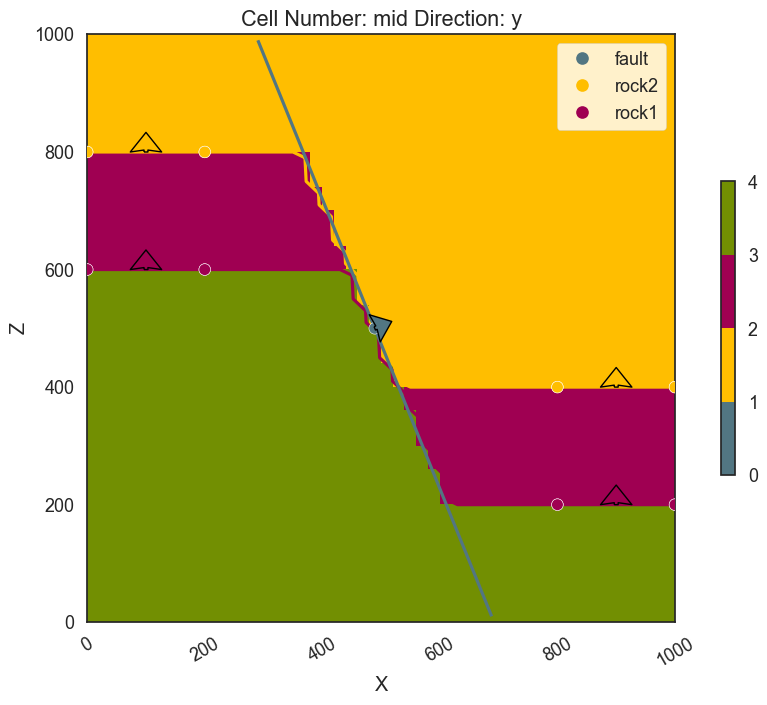

In [7]:
# Generate one realization
x_sample, G_z_sample = stochastic_geomodel()
print(f"Sampled X-value (location): {x_sample}")
print(f"Sampled component of orientation: {G_z_sample}")

gpv.plot_2d(geo_model)

### 3) Multiple realizations

Now we wrap the above part into a function and create containers to save the results for multiple realizations.

In [8]:
# COnvenience function to suppress gempys print statements
def suppress_print(func, *args, **kwargs):
    # Save the original sys.stdout
    original_stdout = sys.stdout
    try:
        # Redirect stdout to null
        sys.stdout = open(os.devnull, 'w')
        return func(*args, **kwargs)
    finally:
        # Restore original stdout
        sys.stdout = original_stdout

In [9]:
# Define the Pyro probabilistic model
def stochastic_geomodel():
    # Define a probabilistic distribution for the Z-coordinate of the surface point
    x_val = pyro.sample("x_val", dist.Normal(500, 100))  # Mean = 630, Std Dev = 20
    # Define a probabilistic distribution for the Z component of the pole vector of the orientation
    G_z_val = pyro.sample("G_z_val", dist.Normal(0.5, 0.3))
    
    # Update the geological model (surface point)
    gp.modify_surface_points(
        geo_model=geo_model,
        slice=0,
        X=x_val.item()  # Convert tensor to Python scalar
    )

    # Update the geological model (Orientation)
    gp.modify_orientations(
        geo_model=geo_model,
        slice=0,
        X=x_val.item(),  # Convert tensor to Python scalar
        G_z=G_z_val.item()
    )
    
    # Recompute the model
    #gp.compute_model(geo_model, engine_config=gp.data.GemPyEngineConfig(
    #    backend=AvailableBackends.PYTORCH));

    # Recompute the model with suppressed printing
    suppress_print(gp.compute_model, geo_model, engine_config=gp.data.GemPyEngineConfig(
        backend=AvailableBackends.PYTORCH))
    
    # extract litho block info in slice
    litho_slice = geo_model.solutions.raw_arrays.lith_block.reshape((resolution))[:,1,:].transpose()

    # extract scalar fields
    scalar_field = geo_model.solutions.raw_arrays.scalar_field_matrix[1].reshape(resolution)[:,1,:].transpose()
    scalar_field_fault = geo_model.solutions.raw_arrays.scalar_field_matrix[0].reshape(resolution)[:,1,:].transpose()

    # extract scalar field values at surface points
    scalar_field_at_surface_points = geo_model.solutions.raw_arrays.scalar_field_at_surface_points[1]
    scalar_field_at_surface_points_faults = geo_model.solutions.raw_arrays.scalar_field_at_surface_points[0]

    return x_val, G_z_val, litho_slice, scalar_field, scalar_field_fault, scalar_field_at_surface_points, scalar_field_at_surface_points_faults  

In [10]:
%%time

# Define number of realizations
n = 100

# Create arrays to store results
litho_slices = np.empty(shape=(n, resolution[2], resolution[0]))
scalar_field_slices = np.empty(shape=(n, resolution[2], resolution[0]))
scalar_field_fault_slices = np.empty(shape=(n, resolution[2], resolution[0]))
scalar_field_values = np.empty(shape=(n, 2))
scalar_field_values_fault = np.empty(shape=(n, 1))
x_vals = np.empty(shape=(n))
G_z_vals = np.empty(shape=(n))

# Generate multiple realizations
for i in tqdm.tqdm(range(n)):
    x, G_z, litho_slice, scalar_field, scalar_field_fault, scalar_field_at_surface_points, scalar_field_at_surface_points_faults = stochastic_geomodel()
    litho_slices[i,:,:] = litho_slice
    scalar_field_slices[i,:,:] = scalar_field
    scalar_field_fault_slices[i,:,:] = scalar_field_fault
    scalar_field_values[i,:] = scalar_field_at_surface_points
    scalar_field_values_fault[i,:] = scalar_field_at_surface_points_faults
    x_vals[i] = x
    G_z_vals[i] = G_z

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:02<00:00,  4.23s/it]

CPU times: total: 1h 2min 13s
Wall time: 7min 2s


### 4) Saving and loading the results

In [11]:
# Define a filename
filename = "uq_results.npz"

# Save all generated realizations
np.savez_compressed(filename, 
                    litho_slices=litho_slices,
                    scalar_field_slices=scalar_field_slices,
                    scalar_field_fault_slices=scalar_field_fault_slices,
                    scalar_field_values=scalar_field_values,
                    scalar_field_values_fault=scalar_field_values_fault,
                    x_vals=x_vals,
                    G_z_vals=G_z_vals)

print(f"Results saved to {filename}")

Results saved to uq_results.npz


In [12]:
# Loading the results
uq_results = np.load('uq_results.npz')

uq_results = np.load('uq_results.npz')
litho_slices, scalar_field_slices, scalar_field_fault_slices, scalar_field_values, scalar_field_values_fault, x_vals, G_z_vals = (uq_results[key] for key in uq_results)


### 5) Visualization

Text(0.5, 1.0, 'Mean Lithology Realizations')

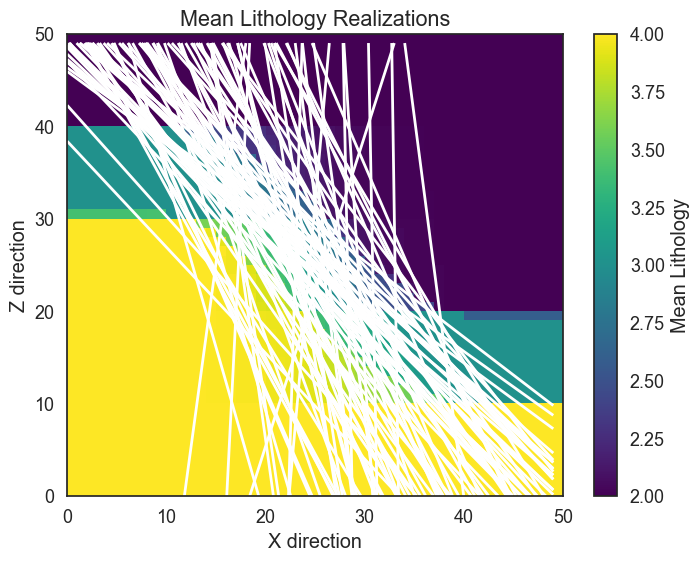

In [13]:
# Spaghetti plot
plt.figure(figsize=(8, 6))  # Set figure size
plt.pcolormesh(np.mean(litho_slices, axis=0), cmap="viridis")  # Apply colormap
plt.colorbar(label="Mean Lithology")  # Add colorbar with label

for i in range(n):
    plt.contour(scalar_field_fault_slices[i], 
                levels=scalar_field_values_fault[i],  # Contour levels
                colors="white",  # Set line color
                linewidths=2,
                alpha=1,
                linestyles="solid")  # Reduce line thickness
    
plt.xlabel("X direction")  # Customize labels
plt.ylabel("Z direction")
plt.title("Mean Lithology Realizations")


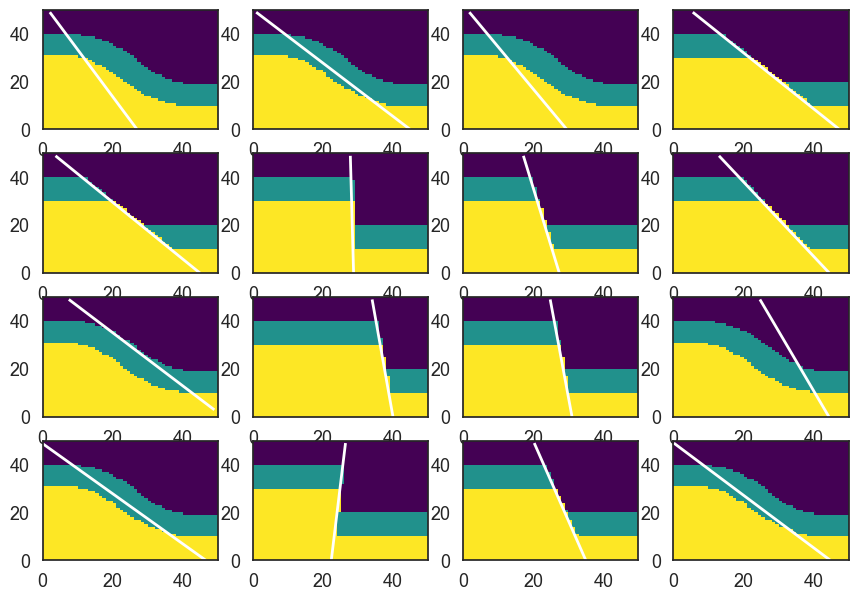

In [14]:
# make a 4x4 plot to show multiple realizations

fig, axs = plt.subplots(nrows=4, ncols=4)

counter = 0
for i in range(4):
    for j in range(4):
        axs[i][j].pcolormesh(litho_slices[counter], cmap="viridis")
        
        axs[i][j].contour(scalar_field_fault_slices[counter], 
                levels=scalar_field_values_fault[counter],  # Contour levels
                colors="white",  # Set line color
                linewidths=2,
                alpha=1,
                linestyles="solid")  # Reduce line thickness

        # axs[i][j].contour(scalar_field_slices[counter], 
        #         levels=np.flip(scalar_field_values[i]),  # Contour levels
        #         colors="black",  # Set line color
        #         linewidths=1,
        #         alpha=1,
        #         linestyles="solid") 
        
        counter+=1

In [15]:
# Histogram fo sampled x locations
# plt.hist(x_vals, bins=20);

In [16]:
# Histogram fo sampled G_z components of pole vector 
# plt.hist(G_z_vals, bins=20);